In [1]:
%cd E:\river_seg\airc

E:\river_seg\airc


# Environment


In [2]:
import os
from pathlib import Path
import tqdm
import json
import datetime
from copy import copy, deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import  partial
from queue import PriorityQueue, Queue
import warnings
import heapq
from heapq import heappush, heappop

import torch
import sam2
from sam2.build_sam import build_sam2, build_sam2_hf
from sam2.sam2_image_predictor import SAM2ImagePredictor as SAM

import cv2
import numpy as np
from PIL import  Image
import scipy
import skimage

import segmentationmetrics as segmetrics

In [3]:
import rootutils
rootutils.set_root(r"E:\river_seg\airc", pythonpath=True)

In [4]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(1000000000)

from src.zero_shot.sam import SamInferer
from src.zero_shot.utils import save_gray, save_grey, sigmoid
import src.zero_shot.utils as utils

3000


In [5]:
def prepare(out_dir):
    # os.system(f"rm -rf {out_dir}")
    # if os.path.isdir(out_dir):
    #     shutil.rmtree(out_dir)
    (out_dir / "strong").mkdir(parents=True, exist_ok=True)
    (out_dir / "weak").mkdir(parents=True, exist_ok=True)
    (out_dir / "logit").mkdir(parents=True, exist_ok=True)
    (out_dir / "output").mkdir(parents=True, exist_ok=True)
    (out_dir / "image").mkdir(parents=True, exist_ok=True)
    (out_dir / "thin").mkdir(parents=True, exist_ok=True)
    (out_dir / "skeleton").mkdir(parents=True, exist_ok=True)
    (out_dir / "ensembled_output").mkdir(parents=True, exist_ok=True)
    (out_dir / "confidence").mkdir(parents=True, exist_ok=True)

In [6]:
def plot_metric_distributions(per_sample_metrics, bins=20, out_dir=None, prefix="", ):
    """
    per_sample_metrics: dict from compute_per_sample_multilabel_metrics
    bins: number of histogram bins
    """
    for name, values in per_sample_metrics.items():
        values = np.asarray(values, dtype=float)
        values[np.isinf(values)] = 0
        plt.figure()
        plt.hist(values, bins=bins, density=True, align='right')
        plt.title(f"Distribution of {name}")
        plt.xlabel(name)
        plt.ylabel("Percentage")
        plt.grid(True)
        plt.show()
        if out_dir is not None:
            plt.savefig(os.path.join(out_dir, f"{prefix}_Distribution_of_{name}"))

# Testing

In [7]:
attb = datetime.datetime.now()
exp_time = f"{attb.year}_{attb.month}_{attb.day}-{attb.hour}_{attb.minute}_{attb.second}"
print(exp_time)

2025_11_21-8_52_29


In [8]:
year = 2015
image_path = f"data/v2/{year}.png"
# /work/hpc/potato/airc/data/viz
root_dir = Path(f"output/{exp_time}")
template = "{0}_v4.jpg"
model = "sam2.1_hiera_s"
checkpoint = f"../checkpoints/{model}.pt"
model_cfg = f"configs/sam2.1/{model}.yaml"
model_id =  f"facebook/{model}"
first_pts = (565, 1655)
patch_size = [512, 512]
log_size = [128, 128]
trial = 0

In [9]:
kwargs = {'cfg': model_cfg, 
          'ckpt': checkpoint, 
          'roi': [128, 128],
          'root_area': 800,
          'max_roots': 2,
         'patience': 3,
         'beta': 0.7,
         'd_alpha': 0.1,
         'alpha': 0.25,
         'decay': 0.7,
         'patch_size': patch_size,
         'thresh': 0.95,
         'fill_kernel_size': 5,
         'thresh': 0.95,
         'min_length': 100, 
         'sampling_dis': 300, 
         'back_off': 15,
         'neg_sampling_grid': 6,
         'neg_dis': 15,
         'pos_dis': 30,
         'pos_rad': 200,
         'pos_sc': 2.,
         'confidence': 0.9,
         'topk': 2,
         'stable_weight': 1.5,
         'post_act': False,
         'gamma': 2.
         }



In [10]:
param = SamInferer(**kwargs)
marker = cv2.imread(r"data\negative_region.png")[..., -1]
marker = (marker < 250)

In [11]:
eval_res = defaultdict(list)

In [12]:
trial += 1
param.reset()
param.marker = marker.copy()
out_dir = root_dir / f"{trial:02d}" / f"{param.beta:.2f}" / f"{year}"
prepare(out_dir)
with open(f"{out_dir}/config_{kwargs['beta']}_{kwargs['alpha']}.json", "w") as file:
    json.dump(kwargs, file, indent=4)
iterations = 0
param.read(image_path)
param.add_queue({'pt': np.array(first_pts)}, isroot=True)
param.neg = np.array([[275, 1100], [365, 1360], [900, 2050], [910, 2050], [5964, 3275]])
pbar = tqdm.tqdm(range(200), desc="Inference process")
for iter in pbar:
    pbar.refresh()
    pbar.set_description_str(f"{year}_{param.beta:.2f}_{trial:02d}")
    filename = f"iter_{iter}"
    if len(param.queue) == 0:
        break
    iterations += 1
    # print(f"Iteration {iterations}")
    output = param.iter(debug=True)
    if output['ret'] is True:           
        if eval_res is None: 
            eval_res = dict(zip(output['metrics'].keys(), [[]] * len(output['metrics'])))
        # print(output['metrics'])
        # print(output['infer']['logit'].min())
        save_gray(f"{out_dir}/logit/{filename}.jpg", sigmoid(np.concatenate([sigmoid(output['infer']['logit']), output['prob_map']], axis=0)), 'viridis', output_size=log_size)
        save_gray(f"{out_dir}/thin/{filename}.jpg", output['thin'], 'viridis', nonzero=False, output_size=log_size)
        save_gray(f"{out_dir}/weak/{filename}.jpg", output['possible'], 'viridis', nonzero=False, output_size=log_size)
        save_gray(f"{out_dir}/strong/{filename}.jpg", output['beta'], 'viridis', nonzero=False, output_size=log_size)
        # save_gray(f"{out_dir}/output/{filename}.jpg", output['prob_map'], 'viridis', output_size=log_size)
        # save_gray(f"{out_dir}/confidence/{filename}.jpg", np.concatenateoutput['prob_map'], 'viridis', output_size=log_size)
        save_gray(f"{out_dir}/skeleton/{filename}.jpg", output['skeleton'], 'viridis', invert=True, output_size=log_size)
        image = output['infer']['input'].copy().astype('float') / 255
        input_mask = scipy.ndimage.morphological_gradient(output['infer']['inp_mask'], size=3)
        src, dst = param.root, param.root + param.patch_size
        label_mask = scipy.ndimage.morphological_gradient(param.label[src[0]:dst[0], src[1]:dst[1]].copy(), size=3)
        pred_mask = scipy.ndimage.morphological_gradient(output['beta'].copy(), size=3)
        # print(image.shape, input_mask.shape, a_label.shape, output['beta'].shape)
        image = image * (1 - np.stack([input_mask, label_mask, pred_mask], axis=-1).max(axis=-1)[..., None]) \
                + input_mask[..., None] * np.array([1, 0, 0])[None, None, :] \
                + label_mask[..., None] * np.array([0, 1, 0])[None, None, :] \
                + pred_mask[..., None] * np.array([0, 0, 1])[None, None, :]
        
        annotation = output['infer']['pts']
        a_label = output['infer']['label'][:, None]
        color = [0, 1, 0, 0.5] * a_label + [1, 0, 0, 0.5] * (1 - a_label)
        for pt, c in zip(annotation, color):
            cv2.circle(image, pt, 5, c, -1)
        
        cmap = plt.get_cmap('hsv')

        for i in range(output['roots']['pts'].shape[0]):
            pt, di = output['roots']['pts'][i], output['roots']['directions'][i]
            cv2.circle(image, pt[::-1], 20, [0.5, 1, 0, 0.5], 1)
            if np.linalg.norm(di.copy()) > 0:
                # print(f"Direction {di}")
                root_dst = (pt + di * 80).astype(int)
                # print(root_dst)
                cv2.arrowedLine(image, pt[::-1], root_dst[::-1], [0.5, 1, 0, 0.5], 2)
            else: 
                print(f"Graph root {pt} is stationary")
        
        branches = [np.array(branch) for (cost, branch) in output['branches']]
        for i, branch in enumerate(branches):
            c_val = list(cmap(0.1 + 0.9 * (float(i) / len(branches))))
            c_val[-1] = 0.3
            # rgb = (int(c_val[0] * 255), int(c_val[1] * 255), int(c_val[2] * 255))
            cv2.polylines(image, [branch[:, ::-1]], False, c_val, 1)
            cv2.circle(image, branch[0, ::-1], 10, c_val[:3], 1)
        # cv2.imwrite(f"{out_dir}/image/{filename}.jpg", (image * 255)[..., ::-1].astype(np.uint8))
        plt.imshow(image)
        plt.pause(0.2)
        cv2.imwrite(f"{out_dir}/output/{filename}.jpg", (image * 255)[..., ::-1])
        for key in output['metrics'].keys():
                eval_res[key].append(float(output['metrics'][key]))

2015_0.70_01:   0%|          | 0/200 [00:06<?, ?it/s]     


NameError: name 'fpr' is not defined

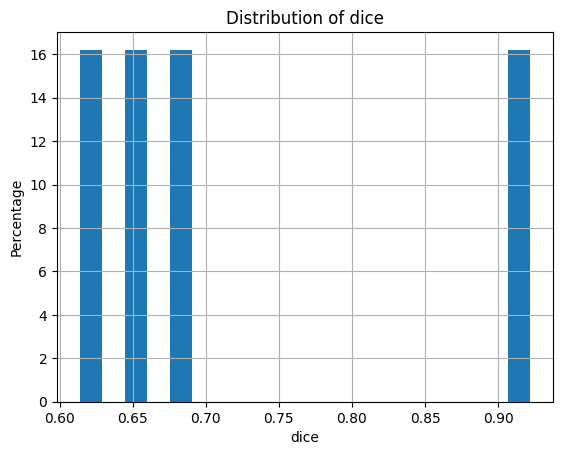

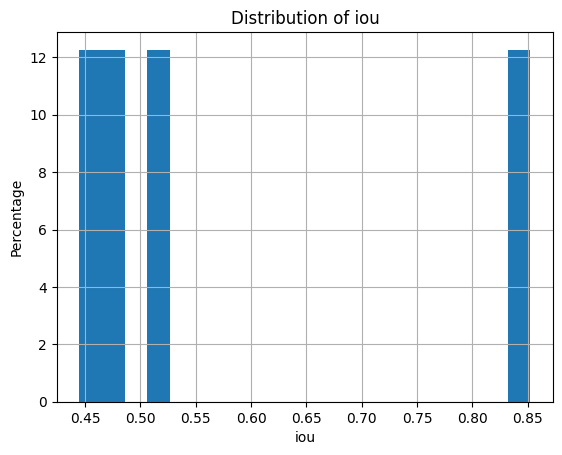

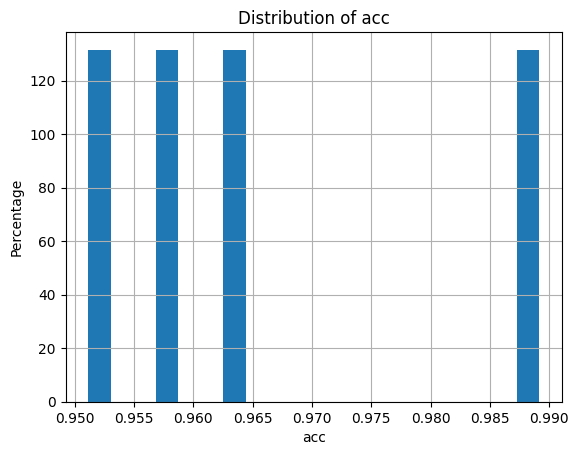

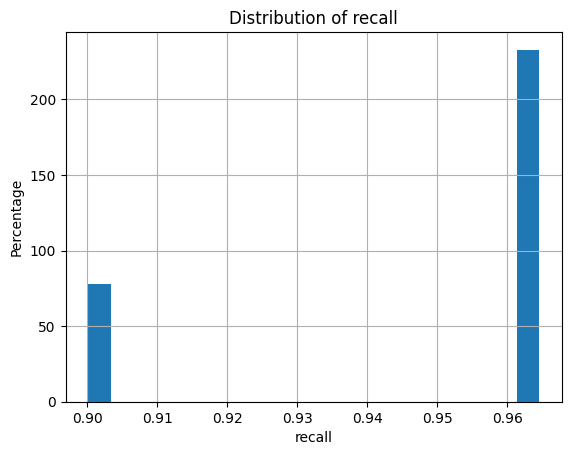

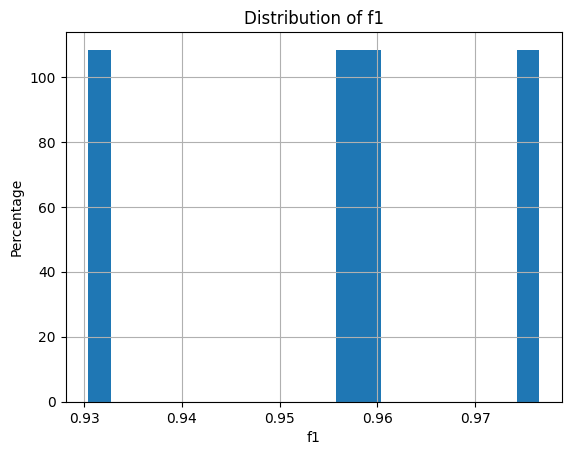

In [ ]:
plot_metric_distributions(eval_res, prefix="Per-sample results")